# Introduction


We use Ocular Disease Recognition dataset to train a model for Cataract prediction - from eye fundus exam & dyagnosis notes.

In the dataset, annotations were added by trained human readers with quality control management. They classify patient into eight labels including:

* Normal (N);  
* Diabetes (D);  
* Glaucoma (G);  
* Cataract (C);  
* AMD (A);  
* Hypertension (H);  
* Myopia (M);
* Other diseases/abnormalities (O)  

We will select a subset of images for which we can definitely identify if there is a certain pathology (from the associated flag) and which eye is identified with the issue (from the eye diagnosys notes for each eye).

We focus on Cataract.


# Data preparation


## Load packages

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
IMG_SIZE = 224
BATCH_SIZE = 32
NO_EPOCHS = 50
NUM_CLASSES = 2
DATA_FOLDER = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/Training Images"
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import cv2 as cv
from random import shuffle 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
import tensorflow as tf
%matplotlib inline 


## Load tabelar data (Excel)

In [2]:
data_df = pd.read_excel(open("/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/data.xlsx", 'rb'), sheet_name='Sheet1')  

In [3]:
data_df.columns = ["id", 'age', "sex", "left_fundus", "right_fundus", "left_diagnosys", "right_diagnosys", "normal",
                  "diabetes", "glaucoma", "cataract", "amd", "hypertension", "myopia", "other"]

# Train images

Let's check which images have the `Cataract` flag positive and which images have the eye diagnosys associated clearly stating either `cataract` or `normal`


In [4]:
print(data_df.loc[(data_df.cataract==1)].shape)
print(data_df.loc[data_df.cataract==0].shape)

(212, 15)
(3288, 15)


In [5]:
data_df.loc[(data_df.cataract==1)]['left_diagnosys'].value_counts()

cataract                                                                   135
normal fundus                                                               24
cataract，lens dust                                                           8
moderate non proliferative retinopathy                                       6
mild nonproliferative retinopathy                                            5
lens dust，cataract                                                           5
lens dust，normal fundus                                                      4
cataract，moderate non proliferative retinopathy                              3
normal fundus，lens dust                                                      3
refractive media opacity                                                     3
severe proliferative diabetic retinopathy                                    2
cataract，mild nonproliferative retinopathy                                   2
moderate non proliferative retinopathy，cataract     

In [6]:
data_df.loc[(data_df.cataract==1)]['right_diagnosys'].value_counts()

cataract                                                                  127
normal fundus                                                              24
moderate non proliferative retinopathy                                      9
cataract，lens dust                                                          6
lens dust，cataract                                                          5
drusen                                                                      5
mild nonproliferative retinopathy                                           4
refractive media opacity                                                    4
epiretinal membrane                                                         3
macular epiretinal membrane                                                 3
moderate non proliferative retinopathy，cataract                             3
cataract，moderate non proliferative retinopathy                             3
hypertensive retinopathy，cataract                               

In [7]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0

In [8]:
data_df['le_cataract'] = data_df['left_diagnosys'].apply(lambda x: has_cataract_mentioned(x))
data_df['re_cataract'] = data_df['right_diagnosys'].apply(lambda x: has_cataract_mentioned(x))

In [9]:
cataract_le_list = data_df.loc[(data_df.cataract==1) & (data_df.le_cataract==1)]['left_fundus'].values
cataract_re_list = data_df.loc[(data_df.cataract==1) & (data_df.re_cataract==1)]['right_fundus'].values
print(len(cataract_le_list), len(cataract_re_list))
non_cataract_le_list = data_df.loc[(data_df.cataract==0) & (data_df.left_diagnosys=="normal fundus")]['left_fundus'].sample(150).values
non_cataract_re_list = data_df.loc[(data_df.cataract==0) & (data_df.right_diagnosys=="normal fundus")]['right_fundus'].sample(150).values
print(len(non_cataract_le_list), len(non_cataract_re_list))

159 154
150 150


In [10]:
cataract_list = np.concatenate((cataract_le_list, cataract_re_list), axis = 0)
non_cataract_list = np.concatenate((non_cataract_le_list, non_cataract_re_list), axis = 0)
print(len(non_cataract_list), len(cataract_list))

300 313


In [11]:
print(len(os.listdir(DATA_FOLDER)))

7000


In [12]:
def label_image(label):
    if label == 1:
        return [1,0]
    elif label == 0: 
        return [0,1]

def process_data(data_image_list, DATA_FOLDER, is_cataract):
    data_df = []
    for img in tqdm(data_image_list):
        path = os.path.join(DATA_FOLDER,img)
        label = label_image(is_cataract)
        img = cv.imread(path,cv.IMREAD_COLOR)
        img = cv.resize(img, (IMG_SIZE,IMG_SIZE))
        data_df.append([np.array(img),np.array(label)])
    shuffle(data_df)
    return data_df

In [13]:
cat_df = process_data(cataract_list, DATA_FOLDER, 1)

100%|██████████| 313/313 [00:16<00:00, 18.81it/s]


In [14]:
cat_no_df = process_data(non_cataract_list, DATA_FOLDER, 0)

100%|██████████| 300/300 [00:16<00:00, 18.00it/s]


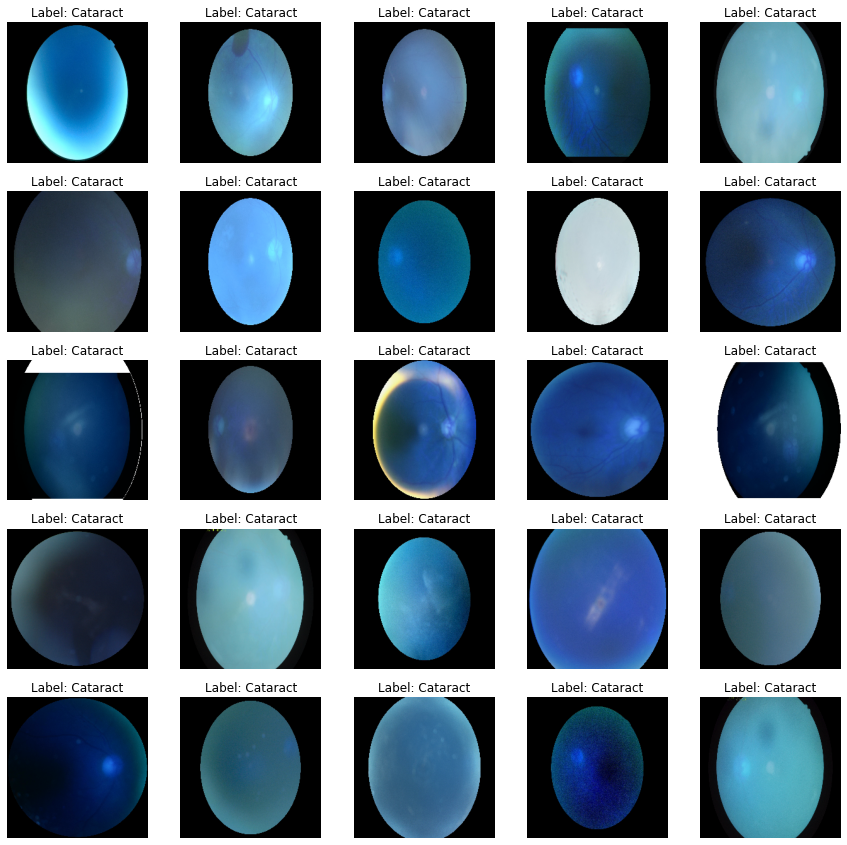

In [15]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(5,5, figsize=(15,15))
    for i,data in enumerate(data[:25]):
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)
        if label  == 0: 
            str_label='Cataract'
        elif label == 1: 
            str_label='No Cataract'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

show_images(cat_df)

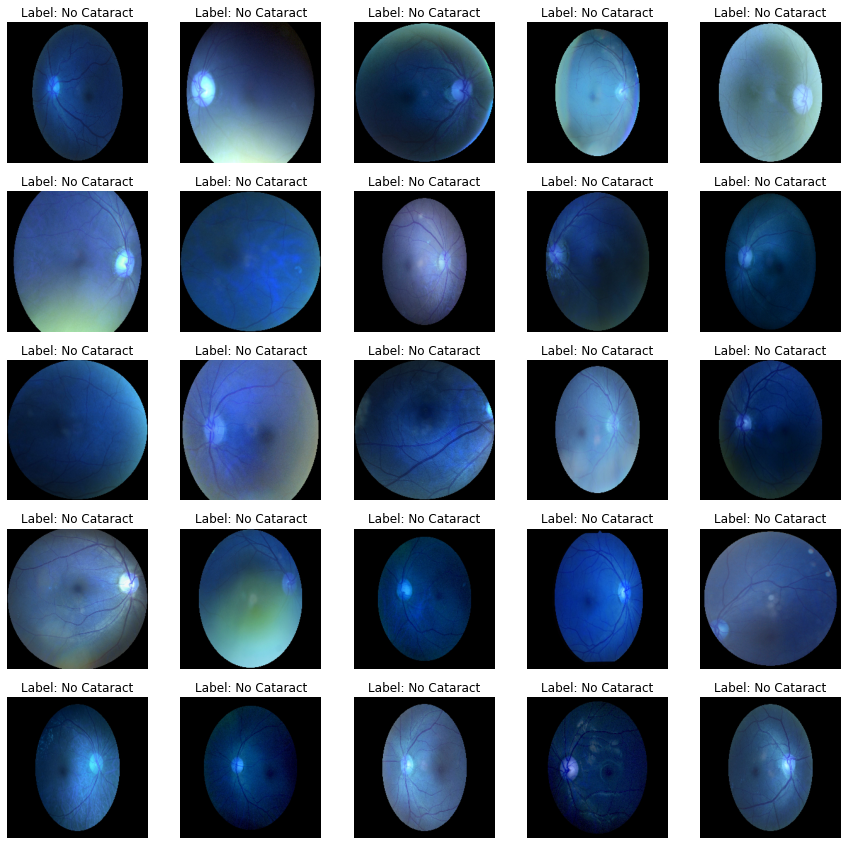

In [16]:
show_images(cat_no_df)

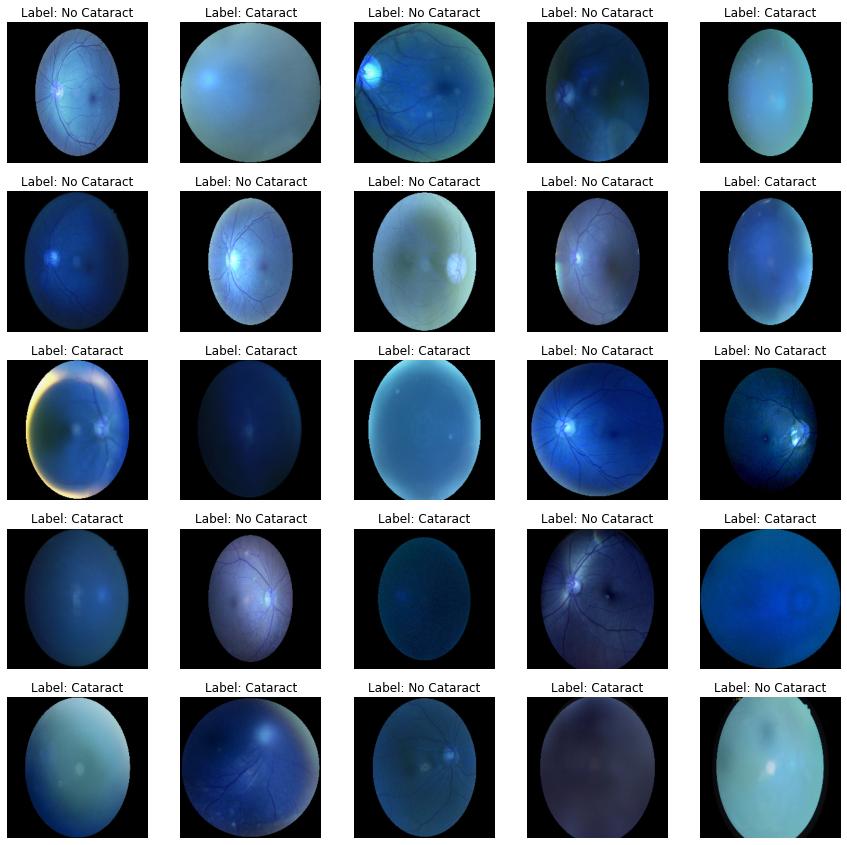

In [17]:
train = cat_df + cat_no_df
shuffle(train)
show_images(train)

In [18]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in train])

# Train model

In [19]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
# ResNet-50 model is already trained, should not be trained
model.layers[0].trainable = True

94773248/94765736 [==============================] - 1s 0us/step


In [20]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


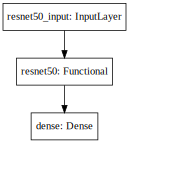

In [22]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

## Train model

In [24]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
16/16 [==============================] - 4s 260ms/step - loss: 27.0194 - accuracy: 0.5898 - val_loss: 10188214.0000 - val_accuracy: 0.5122
Epoch 2/50
16/16 [==============================] - 3s 168ms/step - loss: 1.5863 - accuracy: 0.7673 - val_loss: 58784.7891 - val_accuracy: 0.4878
Epoch 3/50
16/16 [==============================] - 3s 168ms/step - loss: 2.1412 - accuracy: 0.8469 - val_loss: 20114.9531 - val_accuracy: 0.4878
Epoch 4/50
16/16 [==============================] - 3s 167ms/step - loss: 1.2326 - accuracy: 0.8878 - val_loss: 2435.5583 - val_accuracy: 0.4959
Epoch 5/50
16/16 [==============================] - 3s 167ms/step - loss: 1.2468 - accuracy: 0.8857 - val_loss: 499.3243 - val_accuracy: 0.5285
Epoch 6/50
16/16 [==============================] - 3s 178ms/step - loss: 0.2227 - accuracy: 0.9224 - val_loss: 155.0025 - val_accuracy: 0.5772
Epoch 7/50
16/16 [==============================] - 3s 169ms/step - loss: 0.2082 - accuracy: 0.9347 - val_loss: 37.8613 - val

## Validation results

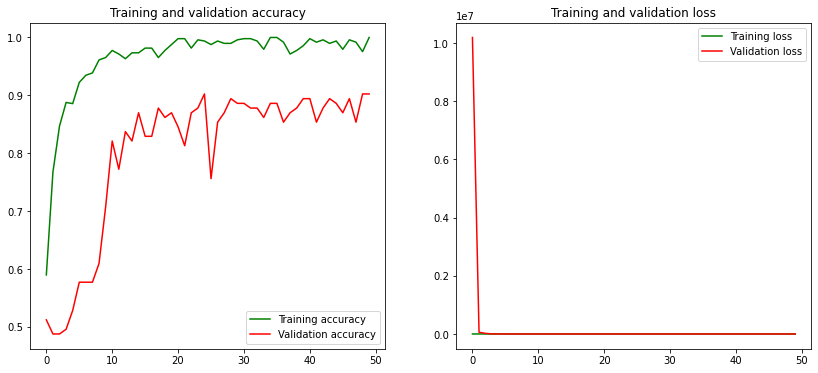

In [25]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

In [26]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.6658346652984619
Validation accuracy: 0.9024389982223511


In [27]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_val)
#get the indices to be plotted
y_true = np.argmax(y_val,axis=1)

In [28]:
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

In [29]:
target_names = ["Cataract", "Normal"]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Cataract       0.90      0.90      0.90        63
      Normal       0.90      0.90      0.90        60

    accuracy                           0.90       123
   macro avg       0.90      0.90      0.90       123
weighted avg       0.90      0.90      0.90       123

